### Problem Statement

Forecast the CocaCola prices data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
coca_cola=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
coca_cola.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


### Data Understanding

In [3]:
coca_cola.shape

(42, 2)

In [4]:
coca_cola.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
coca_cola.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
coca_cola[coca_cola.duplicated()]

,Quarter,Sales


### Data Preparation

In [7]:
coca_cola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [8]:
coca_cola['date']=pd.to_datetime(['19'+x[3:5]+'-'+x[:2] for x in coca_cola['Quarter']])
coca_cola.head()

,Quarter,Sales,date
0,Q1_86,1734.827000,1986-01-01
1,Q2_86,2244.960999,1986-04-01
2,Q3_86,2533.804993,1986-07-01
3,Q4_86,2154.962997,1986-10-01
4,Q1_87,1547.818996,1987-01-01


In [9]:
coca_cola['year']=coca_cola['date'].dt.strftime('%Y')
coca_cola['month']=coca_cola['date'].dt.strftime('%b')
coca_cola.head()

,Quarter,Sales,date,year,month
0,Q1_86,1734.827000,1986-01-01,1986,Jan
1,Q2_86,2244.960999,1986-04-01,1986,Apr
2,Q3_86,2533.804993,1986-07-01,1986,Jul
3,Q4_86,2154.962997,1986-10-01,1986,Oct
4,Q1_87,1547.818996,1987-01-01,1987,Jan


### Data Visualization

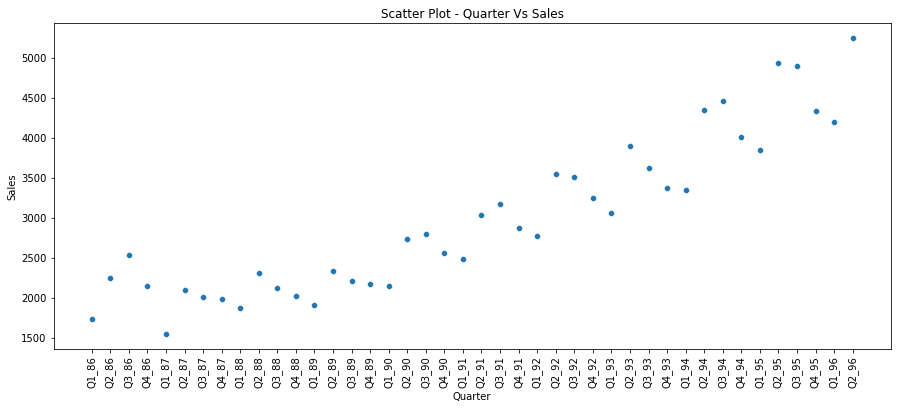

In [10]:
plt.figure(figsize=(15,6))
fig=sns.scatterplot(coca_cola.Quarter,coca_cola.Sales)
plt.title('Scatter Plot - Quarter Vs Sales')
fig.set_xticklabels(rotation=90,labels=coca_cola.Quarter)
plt.show()

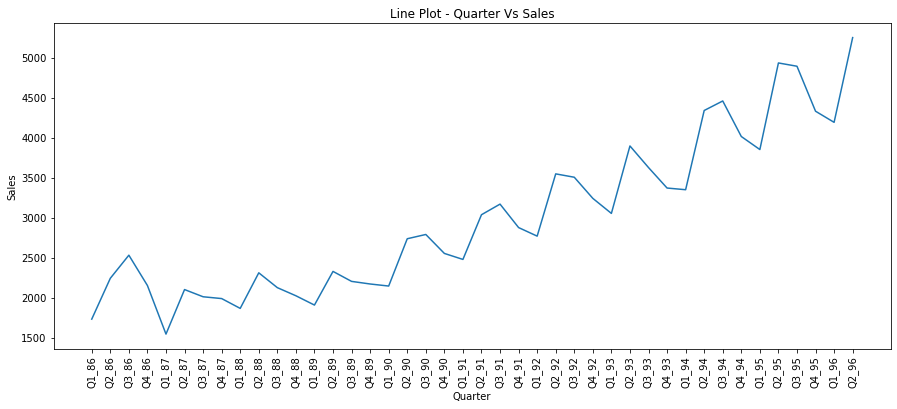

In [11]:
plt.figure(figsize=(15,6))
fig=sns.lineplot(coca_cola.Quarter,coca_cola.Sales)
fig.set_xticklabels(rotation=90,labels=coca_cola.Quarter)
plt.title('Line Plot - Quarter Vs Sales')
plt.show()

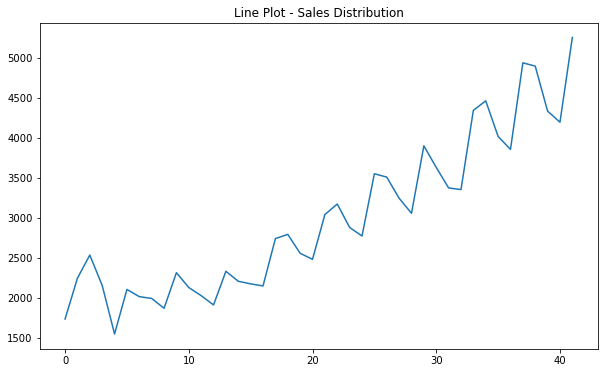

In [12]:
coca_cola.Sales.plot(figsize=(10,6))
plt.title('Line Plot - Sales Distribution')
plt.show()

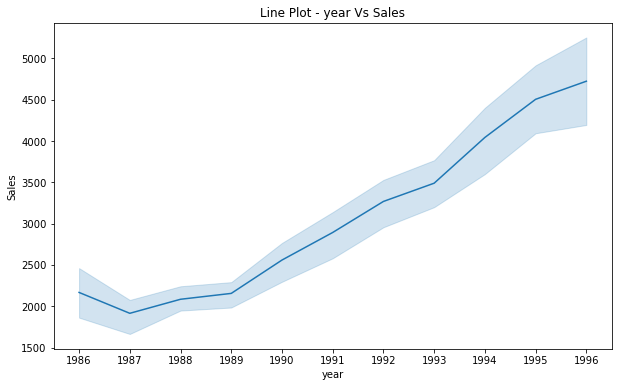

In [13]:
plt.figure(figsize=(10,6))
sns.lineplot(coca_cola.year,coca_cola.Sales)
plt.title('Line Plot - year Vs Sales')
plt.show()

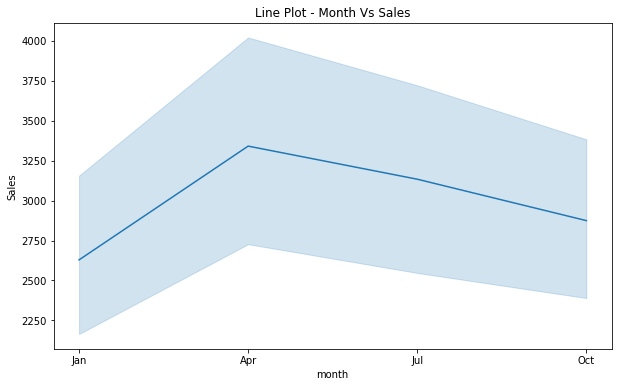

In [14]:
plt.figure(figsize=(10,6))
sns.lineplot(coca_cola.month,coca_cola.Sales)
plt.title('Line Plot - Month Vs Sales')
plt.show()

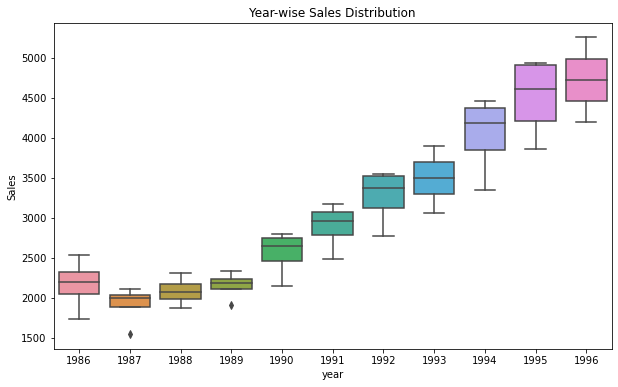

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(coca_cola.year,coca_cola.Sales)
plt.title('Year-wise Sales Distribution')
plt.show()

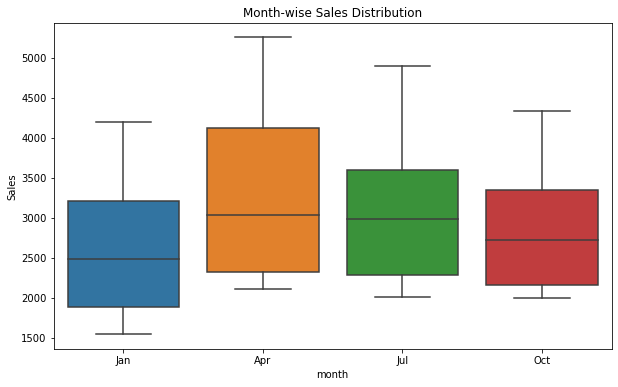

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(coca_cola.month,coca_cola.Sales)
plt.title('Month-wise Sales Distribution')
plt.show()

In [17]:
monthwise=pd.pivot_table(data=coca_cola,values='Sales',index='month',columns='year').round()
monthwise

year,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996
month,,,,,,,,,,,
Apr,2245.0,2104.0,2314.0,2331.0,2739.0,3040.0,3550.0,3899.0,4342.0,4936.0,5253.0
Jan,1735.0,1548.0,1869.0,1911.0,2148.0,2481.0,2772.0,3056.0,3352.0,3854.0,4194.0
Jul,2534.0,2014.0,2128.0,2207.0,2793.0,3172.0,3508.0,3629.0,4461.0,4895.0,NaN
Oct,2155.0,1992.0,2027.0,2174.0,2556.0,2879.0,3244.0,3373.0,4017.0,4333.0,NaN


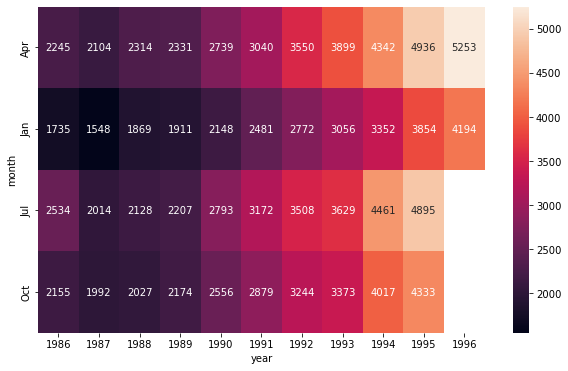

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(monthwise,annot=True,fmt='g')
plt.show()

### Data Preparation - Part 2.

In [19]:
t=np.arange(1,coca_cola.shape[0]+1)
t_square=t*t
log_sales=np.log(coca_cola['Sales'])
dummies=pd.get_dummies(coca_cola['month'])

In [20]:
coca_cola['t']=pd.Series(t)
coca_cola['t_square']=pd.Series(t_square)
coca_cola['log_sales']=pd.Series(log_sales)
coca_cola=coca_cola.join(dummies)

In [21]:
coca_cola.tail()

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct
37,Q2_95,4936.0,1995-04-01,1995,Apr,38,1444,8.504311,1,0,0,0
38,Q3_95,4895.0,1995-07-01,1995,Jul,39,1521,8.495970,0,0,1,0
39,Q4_95,4333.0,1995-10-01,1995,Oct,40,1600,8.374015,0,0,0,1
40,Q1_96,4194.0,1996-01-01,1996,Jan,41,1681,8.341410,0,1,0,0
41,Q2_96,5253.0,1996-04-01,1996,Apr,42,1764,8.566555,1,0,0,0


## 1. Model Driven Forecasting Technique

### Model Building

In [22]:
training_data=coca_cola.head(coca_cola.shape[0]-12)
testing_data=coca_cola.tail(12)
training_data.shape,testing_data.shape

((30, 12), (12, 12))

### Model Training || Model Prediction || Model Evaluation

#### Linear Model

In [23]:
linear_model = smf.ols(formula='Sales~t',data=training_data).fit()

pred_linear=linear_model.predict(testing_data)

linear_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_linear,squared=False),3)
linear_rmse

714.014

#### Exponential Model

In [24]:
exponential_model = smf.ols(formula='log_sales~t',data=training_data).fit()

pred_exponential=exponential_model.predict(testing_data)

exponential_rmse=np.round(mean_squared_error(testing_data['Sales'],np.exp(pred_exponential),squared=False),3)
exponential_rmse

552.282

#### Quadratic Model

In [25]:
quadratic_model = smf.ols(formula='Sales~t+t_square',data=training_data).fit()

pred_quadratic=quadratic_model.predict(testing_data)

quadratic_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_quadratic,squared=False),3)
quadratic_rmse

646.272

#### Additive Seasonality Model

In [26]:
additive_model = smf.ols(formula='Sales~Jan+Apr+Jul+Oct',data=training_data).fit()

pred_additive=additive_model.predict(testing_data)

additive_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_additive,squared=False),3)
additive_rmse

1778.007

#### Additive Seasonality with Quadratic Trend Model

In [27]:
additive_quad_model = smf.ols(formula='Sales~t+t_square+Jan+Apr+Jul+Oct',data=training_data).fit()

pred_additive_quad=additive_quad_model.predict(testing_data)

additive_quad_rmse=np.round(mean_squared_error(testing_data['Sales'],pred_additive_quad,squared=False),3)
additive_quad_rmse

586.053

#### Multiplicative Model

In [28]:
multiplicative_model = smf.ols(formula='log_sales~Jan+Apr+Jul+Oct',data=training_data).fit()

pred_multiplicative=multiplicative_model.predict(testing_data)

multiplicative_rmse=np.round(mean_squared_error(testing_data['Sales'],np.exp(pred_multiplicative),squared=False),3)
multiplicative_rmse

1828.924

### Compare the Results

In [29]:
Model_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Linear','Exponential','Quadrative','Additive','Additive with Quadrative','Multiplicative']),
          "RMSE":pd.Series([linear_rmse,exponential_rmse,quadratic_rmse,additive_rmse,additive_quad_rmse,multiplicative_rmse])})
Model_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
1,Exponential,552.282
4,Additive with Quadrative,586.053
2,Quadrative,646.272
0,Linear,714.014
3,Additive,1778.007
5,Multiplicative,1828.924


#### Since Exponential Model gives straight lines, we will consider next model. ie, Additive with Quadrative from Model Driven Techniques

### Build model for Complete Dataset

In [30]:
coca_cola_test=pd.read_excel('coca_cola_test.xlsx')
coca_cola_test

,date,t,t_square,Jan,Apr,Jul,Oct
0,1996-07-01,43,1849,0,0,1,0
1,1996-10-01,44,1936,0,0,0,1
2,1997-01-01,45,2025,1,0,0,0
3,1997-04-01,46,2116,0,1,0,0
4,1997-07-01,47,2209,0,0,1,0
5,1997-10-01,48,2304,0,0,0,1


In [31]:
final_model = smf.ols(formula='Sales~t+t_square+Jan+Apr+Jul+Oct',data=coca_cola).fit()
pred_final = final_model.predict(coca_cola_test)
coca_cola_test['Predicted']=pred_final
coca_cola_test

,date,t,t_square,Jan,Apr,Jul,Oct,Predicted
0,1996-07-01,43,1849,0,0,1,0,5319.754557
1,1996-10-01,44,1936,0,0,0,1,5137.955882
2,1997-01-01,45,2025,1,0,0,0,5069.668337
3,1997-04-01,46,2116,0,1,0,0,5866.186600
4,1997-07-01,47,2209,0,0,1,0,5942.178733
5,1997-10-01,48,2304,0,0,0,1,5774.444481


In [32]:
full_data=pd.concat([coca_cola,coca_cola_test])
full_data

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct,Predicted
0,Q1_86,1734.827000,1986-01-01,1986,Jan,1,1,7.458663,0,1,0,0,NaN
1,Q2_86,2244.960999,1986-04-01,1986,Apr,2,4,7.716443,1,0,0,0,NaN
2,Q3_86,2533.804993,1986-07-01,1986,Jul,3,9,7.837477,0,0,1,0,NaN
3,Q4_86,2154.962997,1986-10-01,1986,Oct,4,16,7.675529,0,0,0,1,NaN
4,Q1_87,1547.818996,1987-01-01,1987,Jan,5,25,7.344602,0,1,0,0,NaN
5,Q2_87,2104.411995,1987-04-01,1987,Apr,6,36,7.651791,1,0,0,0,NaN
6,Q3_87,2014.362999,1987-07-01,1987,Jul,7,49,7.608058,0,0,1,0,NaN
7,Q4_87,1991.746998,1987-10-01,1987,Oct,8,64,7.596767,0,0,0,1,NaN
8,Q1_88,1869.049999,1988-01-01,1988,Jan,9,81,7.533186,0,1,0,0,NaN
9,Q2_88,2313.631996,1988-04-01,1988,Apr,10,100,7.746574,1,0,0,0,NaN


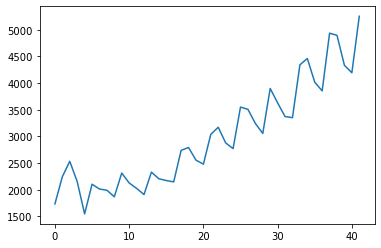

In [33]:
full_data['Sales'].plot()
plt.show()

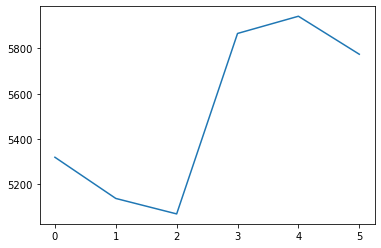

In [34]:
full_data['Predicted'].plot()
plt.show()

<AxesSubplot:>

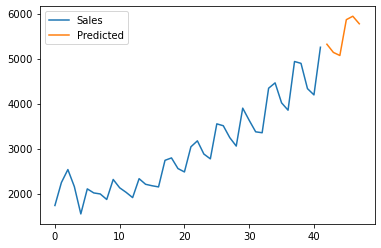

In [35]:
full_data[['Sales','Predicted']].reset_index(drop=True).plot()

## 2. Data Driven Forecasting Techniques

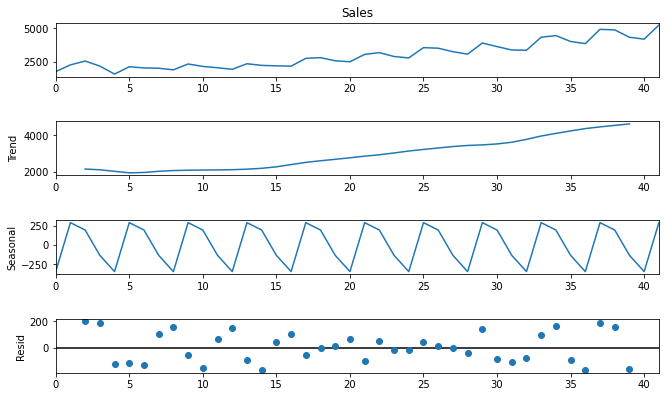

In [36]:
seasonal_de_compose=seasonal_decompose(coca_cola['Sales'],period=4)
fig=seasonal_de_compose.plot()
fig.set_size_inches(10,6)
plt.show()

### Set 1 :

### Simple Average Model

In [37]:
coca_cola['Simple_Average']=pd.Series()
for i in range (0,coca_cola.shape[0]):
    avg=np.round(np.mean(coca_cola['Sales'][:i]))
    coca_cola['Simple_Average'].at[i]=avg
coca_cola.head()

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct,Simple_Average
0,Q1_86,1734.827000,1986-01-01,1986,Jan,1,1,7.458663,0,1,0,0,NaN
1,Q2_86,2244.960999,1986-04-01,1986,Apr,2,4,7.716443,1,0,0,0,1735.0
2,Q3_86,2533.804993,1986-07-01,1986,Jul,3,9,7.837477,0,0,1,0,1990.0
3,Q4_86,2154.962997,1986-10-01,1986,Oct,4,16,7.675529,0,0,0,1,2171.0
4,Q1_87,1547.818996,1987-01-01,1987,Jan,5,25,7.344602,0,1,0,0,2167.0


In [38]:
coca_cola=coca_cola.fillna(0)
coca_cola.head()

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct,Simple_Average
0,Q1_86,1734.827000,1986-01-01,1986,Jan,1,1,7.458663,0,1,0,0,0.0
1,Q2_86,2244.960999,1986-04-01,1986,Apr,2,4,7.716443,1,0,0,0,1735.0
2,Q3_86,2533.804993,1986-07-01,1986,Jul,3,9,7.837477,0,0,1,0,1990.0
3,Q4_86,2154.962997,1986-10-01,1986,Oct,4,16,7.675529,0,0,0,1,2171.0
4,Q1_87,1547.818996,1987-01-01,1987,Jan,5,25,7.344602,0,1,0,0,2167.0


In [39]:
rmse_avg=np.round(mean_squared_error(coca_cola.Sales,coca_cola.Simple_Average,squared=False),3)
rmse_avg

1020.358

### Moving Average Model

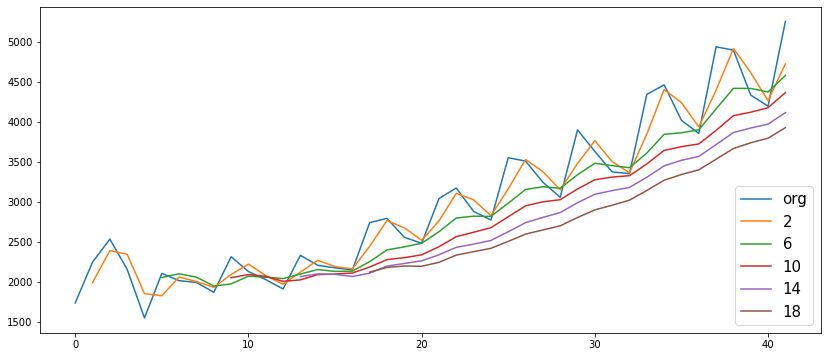

In [40]:
#Plotting Moving average model

plt.figure(figsize=(14,6))
coca_cola['Sales'].plot(label='org')
for i in range(2,19,4):
    coca_cola['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='lower right',fontsize =15)
plt.xticks(np.arange(0,50,10))
plt.show()

In [41]:
coca_cola['Moving_Average']=coca_cola['Sales'].rolling(3).mean().round()

In [42]:
coca_cola=coca_cola.fillna(0)
coca_cola.head()

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct,Simple_Average,Moving_Average
0,Q1_86,1734.827000,1986-01-01,1986,Jan,1,1,7.458663,0,1,0,0,0.0,0.0
1,Q2_86,2244.960999,1986-04-01,1986,Apr,2,4,7.716443,1,0,0,0,1735.0,0.0
2,Q3_86,2533.804993,1986-07-01,1986,Jul,3,9,7.837477,0,0,1,0,1990.0,2171.0
3,Q4_86,2154.962997,1986-10-01,1986,Oct,4,16,7.675529,0,0,0,1,2171.0,2311.0
4,Q1_87,1547.818996,1987-01-01,1987,Jan,5,25,7.344602,0,1,0,0,2167.0,2079.0


In [43]:
rmse_moving_avg=np.round(mean_squared_error(coca_cola.Sales,coca_cola.Moving_Average,squared=False),3)
rmse_moving_avg

530.946

### Weighted Moving Average Model

In [44]:
weights=[0.2,0.3,0.5]
sum_weights=np.sum(weights)

In [45]:
coca_cola['Weighted_Moving_Average']=coca_cola['Sales'].rolling(3).apply(lambda x : np.sum(x*weights)/sum_weights,).round()

In [46]:
coca_cola=coca_cola.fillna(0)
coca_cola.head()

,Quarter,Sales,date,year,month,t,t_square,log_sales,Apr,Jan,Jul,Oct,Simple_Average,Moving_Average,Weighted_Moving_Average
0,Q1_86,1734.827000,1986-01-01,1986,Jan,1,1,7.458663,0,1,0,0,0.0,0.0,0.0
1,Q2_86,2244.960999,1986-04-01,1986,Apr,2,4,7.716443,1,0,0,0,1735.0,0.0,0.0
2,Q3_86,2533.804993,1986-07-01,1986,Jul,3,9,7.837477,0,0,1,0,1990.0,2171.0,2287.0
3,Q4_86,2154.962997,1986-10-01,1986,Oct,4,16,7.675529,0,0,0,1,2171.0,2311.0,2287.0
4,Q1_87,1547.818996,1987-01-01,1987,Jan,5,25,7.344602,0,1,0,0,2167.0,2079.0,1927.0


In [47]:
rmse_weighted_moving_avg=np.round(mean_squared_error(coca_cola.Sales,coca_cola.Weighted_Moving_Average,squared=False),3)
rmse_weighted_moving_avg

489.651

#### Simple Average, Moving average, Weighted Moving average calculation done for finding least RMSE, which is Weighted Moving Average amonth these three.

### Set - 2

### Simple Exponential Smoothing Technique

In [48]:
ses=SimpleExpSmoothing(endog=training_data['Sales']).fit(smoothing_level=0.2)

pred_ses = ses.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_ses=np.round(mean_squared_error(testing_data['Sales'],pred_ses,squared=False),3)
rmse_ses

1153.703

### Holts Technique

In [49]:
holt=Holt(endog=training_data['Sales']).fit(smoothing_level=0.8,smoothing_slope=0.2)

pred_holt = holt.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_holt=np.round(mean_squared_error(testing_data['Sales'],pred_holt,squared=False),3)
rmse_holt

559.52

### Winter's Exponential Technique - Additive Seasonality and Additive Trend

In [50]:
winter_add_add=ExponentialSmoothing(endog=training_data['Sales'],seasonal='add',trend='add',seasonal_periods=12).fit()

pred_winter_add_add = winter_add_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_add_add=np.round(mean_squared_error(testing_data['Sales'],pred_winter_add_add,squared=False),3)
rmse_winter_add_add

417.141

### Winter's Exponential Technique - Multiplicative Seasonality and Additive Trend

In [51]:
winter_mul_add=ExponentialSmoothing(endog=training_data['Sales'],seasonal='mul',trend='add',seasonal_periods=12).fit()

pred_winter_mul_add = winter_mul_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_mul_add=np.round(mean_squared_error(testing_data['Sales'],pred_winter_mul_add,squared=False),3)
rmse_winter_mul_add

212.666

### Compare the Results

In [52]:
pd.set_option('display.max_colwidth',None)
Data_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Simple Exponential Smoothing','Holts','Winters Exponential Technique - Additive Seasonality and Additive Trend','Winters Exponential Technique - Multiplicative Seasonality and Additive Trend']),
          "RMSE":pd.Series([rmse_ses,rmse_holt,rmse_winter_add_add,rmse_winter_mul_add])})
Data_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
3,Winters Exponential Technique - Multiplicative Seasonality and Additive Trend,212.666
2,Winters Exponential Technique - Additive Seasonality and Additive Trend,417.141
1,Holts,559.520
0,Simple Exponential Smoothing,1153.703


#### From Data Driven Models, We can see that Winters Exponential Technique with Multiplicative Seasonality and Additive Treend has least RMSE

### Build model for Complete Dataset

In [53]:
winter_mul_add_final=ExponentialSmoothing(endog=coca_cola['Sales'],seasonal='mul',trend='add',seasonal_periods=4).fit()

winter_mul_add_final.forecast(6)

42    5216.190079
43    4663.475300
44    4502.472863
45    5731.036391
46    5613.076244
47    5011.683296
dtype: float64

## 3. ARIMA

### Evaluate Arima Model

In [54]:
def evaluate_arima_model(X,arima_order):
    train_size=int(len(X)*0.5)
    train,test = X[0:train_size],X[train_size:]
    history = [i for i in train]
    predictions = list()
    for t in range(0,len(test)):
        model = ARIMA(endog =history,order = arima_order).fit(disp=0)
        yhat  = model.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    RMSE = mean_squared_error(test, predictions,squared=False)
    return RMSE

### Grid Search for ARIMA Order

In [55]:
def evaluate_order(dataset, p_values, q_values, d_values):
    dataset = dataset.astype('float32')
    best_score,best_order = float('inf'),None
    for p in p_values:
        for q in q_values:
            for d in d_values:
                try:
                    order = (p,q,d)
                    rmse = evaluate_arima_model(dataset,order)
                    print(f"RMSE is {rmse} and Order is {order}")
                    if rmse < best_score:
                        best_score,best_order = rmse,order
                except:
                    continue
    print(f"Best Score is {best_score} and Best Order is {best_order}")         

In [56]:
data = coca_cola.iloc[:,1]
data = data.values
train_size=int(len(data)-4)
train_data,test_data = data[0:train_size],data[train_size:]
train_data.shape,test_data.shape

((38,), (4,))

In [57]:
p_values = range(0,4)
q_values = range(0,4)
d_values = range(0,4)
warnings.filterwarnings('ignore')
evaluate_order(train_data,p_values, q_values, d_values)

RMSE is 1150.9663502733831 and Order is (0, 0, 0)
RMSE is 820.7838430725903 and Order is (0, 0, 1)
RMSE is 495.8444028029956 and Order is (0, 0, 2)
RMSE is 654.7613972908835 and Order is (0, 0, 3)
RMSE is 479.6469758883936 and Order is (0, 1, 0)
RMSE is 454.9745829596855 and Order is (0, 1, 1)
RMSE is 428.85001617986035 and Order is (0, 1, 2)
RMSE is 395.40945009263595 and Order is (0, 1, 3)
RMSE is 681.1780084411721 and Order is (0, 2, 0)
RMSE is 498.4336254268276 and Order is (0, 2, 1)
RMSE is 445.70560507503143 and Order is (0, 2, 2)
RMSE is 430.40924150144485 and Order is (0, 2, 3)
RMSE is 540.0408053624047 and Order is (1, 0, 0)
RMSE is 478.4642781072046 and Order is (1, 1, 0)
RMSE is 690.2466973371651 and Order is (1, 2, 0)
RMSE is 553.6719015301569 and Order is (2, 0, 0)
RMSE is 359.13230220979494 and Order is (2, 1, 0)
RMSE is 348.83973112563166 and Order is (2, 1, 1)
RMSE is 589.1994320968996 and Order is (2, 2, 0)
RMSE is 443.6200418767692 and Order is (3, 0, 0)
RMSE is 268.5

### Build Model based on Optimum Arima Order

In [58]:
model_final = ARIMA(train_data,(3, 2, 0)).fit()

In [59]:
forecast=model_final.forecast(4)[0].round()
forecast

array([5080., 4657., 4568., 5624.])

In [60]:
test_data

array([4895., 4333., 4194., 5253.])

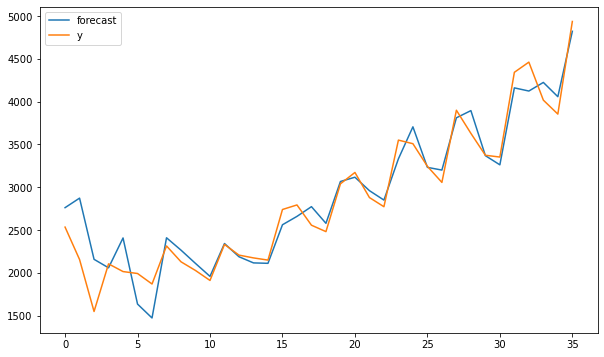

In [61]:
fig=model_final.plot_predict()
fig.set_size_inches(10,6)
plt.show()

In [62]:
RMSE_Optimum = np.round(mean_squared_error(test_data,forecast,squared=False))
RMSE_Optimum

323.0

#### RMSE by ARIMA Model is 323

### Evaluate for complete dataset

In [63]:
model_final_full_dataset = ARIMA(data,(3, 2, 0)).fit()

In [64]:
forecast=model_final_full_dataset.forecast(4)[0].round()
forecast

array([5208., 4658., 4597., 5622.])

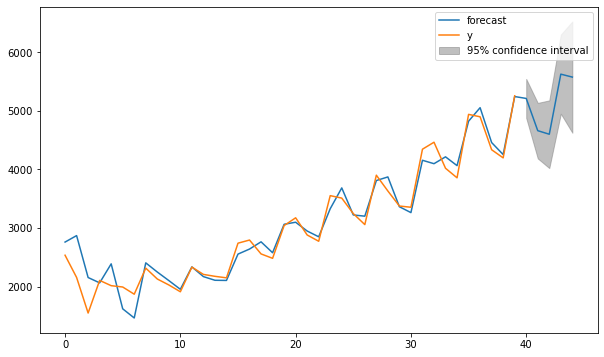

In [65]:
fig=model_final_full_dataset.plot_predict(2,46)
fig.set_size_inches(10,6)
plt.show()

### Comparing to all Models, we can observe that Winters Exponential Technique - Multiplicative Seasonality and Additive Trend Model gives Least RMSE value, followed by ARIMA Model with order (3, 2, 0)

### End !!!